Công thức phân rã ma trận ban đầu:

$\hat r_{u,i} = q_{i}^{T}p_{u}$
* Công thức này biểu diễn xếp hạng dự đoán $\hat r_{u,i}$ cho người dùng $u$ và mục tiêu $i$. Đó là tích vô hướng giữa vector yếu tố tiềm ẩn $q_{i}$ cho mục tiêu $i$ và vector yếu tố tiềm ẩn $p_{u}$ cho người dùng $u$.

Công thức phân rã ma trận với regularization:

$\min\sum(r_{u,i} - q_{i}^{T}p_{u})^2 + \lambda(||q_{i}||^2 + ||p_{u}||^2)$
* Công thức này biểu diễn hàm mục tiêu mà chúng ta muốn tối thiểu hóa. Nó bao gồm hai thành phần: độ chênh lệch bình phương giữa xếp hạng quan sát $r_{u,i}$ và xếp hạng dự đoán $q_{i}^{T}p_{u}$, và thành phần regularization.
* Thành phần đầu tiên, $\sum(r_{u,i} - q_{i}^{T}p_{u})^2$, đo lường sai số bình phương giữa xếp hạng quan sát và xếp hạng dự đoán. Mục tiêu là tối thiểu hóa thành phần này, thúc đẩy xếp hạng dự đoán gần như là xếp hạng quan sát.
* Thành phần thứ hai, $\lambda(||q_{i}||^2 + ||p_{u}||^2)$, là thành phần regularization. Nó giúp ngăn chặn overfitting bằng cách trừng phạt giá trị lớn của vector yếu tố tiềm ẩn $q_{i}$ và $p_{u}$. Tham số regularization $\lambda$ điều khiển mức độ regularization. Bằng cách bao gồm thành phần này, chúng ta khuyến khích các vector yếu tố tiềm ẩn nhỏ hơn và được regularization tốt hơn, điều này thúc đẩy sự tổng quát hóa đến dữ liệu mới.

Công thức phân rã ma trận với xếp hạng ngụ ý:

$\min\sum c_{u,i}(p_{u,i} - q_{i}^{T}p_{u})^2 + \lambda(||q_{i}||^2 + ||p_{u}||^2)$
* Trong công thức này, chúng ta xem xét xếp hạng ngụ ý được tạo ra từ tương tác người dùng với mục tiêu (ví dụ: nhấp chuột, xem, mua hàng, v.v.) thay vì xếp hạng rõ ràng.
* Để tính toán cho các xếp hạng ngụ ý này, chúng ta thêm thành phần $c_{u,i}$ và $p_{u,i}$ vào công thức. Thành phần $c_{u,i}=1+\alpha r_{u,i}$ và $p_{u,i}=1$ nếu $r_{u,i}>0$ và $p_{u,i}=0$ nếu $r_{u,i}=0$. Ở đây, $r_{u,i}$ là biểu diễn số của sở thích của người dùng (ví dụ: số lượt nhấp chuột, v.v.).

In [1]:
import numpy as np
import pandas as pd
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.sql.functions import udf, col, explode, collect_list
import os
os.environ["JAVA_HOME"] = 'C:\Program Files\Java\jdk-20'

In [2]:
appName = "Recommender System"
spark = SparkSession.builder \
    .master("local[2]") \
    .appName(appName) \
    .getOrCreate()
# sc = spark.sparkContext
# sqlContext = SQLContext(sc)


In [3]:
COL_USER = "user_id"
COL_ITEM = "book_id"
COL_RATING = "rating"
MAX_ITER = 10
REG_PARAM = 0.15
RANK = 4

In [4]:
ratings = spark.read.csv('./data/book/ratings.csv',
                         header=True, inferSchema=True)
books = spark.read.csv('./data/book/books.csv', header=True, inferSchema=True)
books = books.withColumn('ratings_count', books['ratings_count'].cast('int'))
books = books.withColumn('average_rating', books['average_rating'].cast('float'))
books = books.drop('work_id', 'isbn', 'isbn13', 'work_ratings_count',
                   'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5')

tags = spark.read.csv('./data/book/tags.csv', header=True, inferSchema=True)
book_tags = spark.read.csv('./data/book/book_tags.csv', header=True, inferSchema=True)


In [5]:
ratings.printSchema()
books.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- book_id: integer (nullable = true)
 |-- rating: integer (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- book_id: integer (nullable = true)
 |-- best_book_id: integer (nullable = true)
 |-- books_count: integer (nullable = true)
 |-- authors: string (nullable = true)
 |-- original_publication_year: double (nullable = true)
 |-- original_title: string (nullable = true)
 |-- title: string (nullable = true)
 |-- language_code: string (nullable = true)
 |-- average_rating: float (nullable = true)
 |-- ratings_count: integer (nullable = true)
 |-- image_url: string (nullable = true)
 |-- small_image_url: string (nullable = true)



In [5]:
training_df, validation_df = ratings.randomSplit([.8, .2]) # tách dữ liệu thành 2 phần, 80% dùng để train, 20% dùng để test

In [6]:
als = ALS(maxIter=MAX_ITER, regParam=REG_PARAM, rank=RANK,
          userCol=COL_USER, itemCol=COL_ITEM, ratingCol=COL_RATING) # khởi tạo model
model = als.fit(training_df) # train model

In [9]:
predictions = model.transform(validation_df) # dự đoán
new_predictions = predictions.filter(col("prediction") != np.nan) # lọc các giá trị dự đoán không phải là nan
evalutor = RegressionEvaluator( 
    metricName="rmse", labelCol="rating", predictionCol="prediction") # đánh giá model

rmse_score = evalutor.evaluate(new_predictions) # tính toán độ chính xác của model
print("Root Mean Square Errr Value :", str(rmse_score)) # in ra độ chính xác của model

Root Mean Square Errr Value : 0.8421677940421523


## Fine tune the model

Trong phần này, chúng ta thảo luận về việc điều chỉnh và tinh chỉnh các thông số của mô hình Spark ALS để cải thiện hiệu suất dự đoán.

Có ba thông số chính cần xem xét:

* rank: Đây là số lượng yếu tố tiềm ẩn trong mô hình phân rã ma trận. Thông thường, nếu chọn giá trị lớn hơn, mô hình sẽ xem xét nhiều yếu tố tiềm ẩn hơn. Tuy nhiên, việc chọn giá trị phù hợp cho rank phụ thuộc vào dữ liệu và yêu cầu cụ thể của bài toán.

* regParam: Đây là tham số regularization để kiểm soát overfitting. Khi giá trị của regParam tăng lên, mô hình sẽ được kiểm soát chặt chẽ hơn, giảm khả năng overfitting. Tuy nhiên, giá trị của regParam cần được lựa chọn dựa trên thực nghiệm để đạt hiệu suất tốt nhất.

* maxIters: Đây là số lượng vòng lặp tối đa mà thuật toán ALS sẽ thực hiện. Việc tăng maxIters có thể giúp mô hình hội tụ tốt hơn đến điểm tối ưu, nhưng cũng tăng thời gian tính toán. Chúng ta cần cân nhắc giữa hiệu suất và thời gian chạy khi chọn giá trị cho maxIters.

Trong quá trình xây dựng mô hình, việc khởi đầu với các giá trị mặc định và sau đó điều chỉnh thông số trong khoảng giá trị để tìm ra tổ hợp thông số tối ưu là một phương pháp tốt. Trên bảng, chúng ta có các thông số được sử dụng cho huấn luyện mô hình ALS cho mục đích nghiên cứu so sánh.

In [27]:
param_dict = {
    "rank": [10, 50, 100],
    "regParam": [0.05, 0.1, 0.15]
} # tạo ra các tham số để tìm ra model tốt nhất
param_grid = ParamGridBuilder()\
    .addGrid(als.rank, param_dict["rank"])\
    .addGrid(als.regParam, param_dict["regParam"])\
    .build() # tạo ra các tham số để tìm ra model tốt nhất

In [28]:
rmse_scores = []
for params in param_grid: # duyệt qua các tham số
    rank, regParam = list(params.values())[0], list(params.values())[1] # lấy ra các tham số
    print(f"Training model with rank={rank} and regParam={regParam}")
    als_test = ALS(
        userCol=COL_USER,
        itemCol=COL_ITEM,
        ratingCol=COL_RATING,
        coldStartStrategy="drop",
        rank=rank,
        regParam=regParam,
    ) # khởi tạo model
    model_test = als_test.fit(training_df)
    predictions_test = model_test.transform(validation_df).filter(
        col("prediction") != np.nan)
    evaluator = RegressionEvaluator(
        metricName="rmse", labelCol="rating", predictionCol="prediction")
    rmse_score = evaluator.evaluate(predictions_test)
    print("Root Mean Square Error = " + str(rmse_score))
    rmse_scores.append(rmse_score)

rmse_scores = [float('%.4f' % x) for x in rmse_scores]
rmse_score_array = np.reshape(
    rmse_scores, (len(param_dict["rank"]), len(param_dict["regParam"])))


Training model with rank=10 and regParam=0.05
Root Mean Square Error = 0.9883257772955402
Training model with rank=10 and regParam=0.15
Root Mean Square Error = 0.8788475384620016
Training model with rank=10 and regParam=0.1
Root Mean Square Error = 0.9065085494517354
Training model with rank=50 and regParam=0.05
Root Mean Square Error = 0.9052043819760277
Training model with rank=50 and regParam=0.15
Root Mean Square Error = 0.8743254927661339
Training model with rank=50 and regParam=0.1
Root Mean Square Error = 0.8854696998154016
Training model with rank=100 and regParam=0.05
Root Mean Square Error = 0.8759597955200795
Training model with rank=100 and regParam=0.15
Root Mean Square Error = 0.8747014419390181
Training model with rank=100 and regParam=0.1
Root Mean Square Error = 0.8799966498777988


<AxesSubplot:xlabel='reg. parameter', ylabel='rank'>

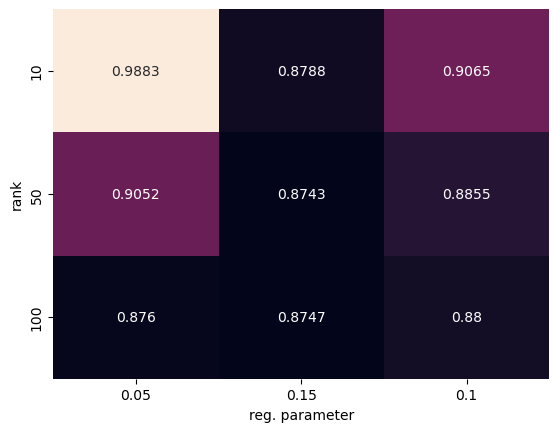

In [29]:
from matplotlib import pyplot as plt
import seaborn as sns

rmse_df = pd.DataFrame(data=rmse_score_array, index=pd.Index(param_dict["rank"], name="rank"),
                       columns=pd.Index(param_dict["regParam"], name="reg. parameter"))
fig, ax = plt.subplots()
sns.heatmap(rmse_df, cbar=False, annot=True, fmt=".4g")


In [10]:
userRecs = model.recommendForAllUsers(10) # lấy ra 10 cuốn sách được recommend cho mỗi user

In [12]:
userRecs.printSchema()

root
 |-- user_id: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- book_id: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



## One user defined function


In [40]:
oneUser = ratings.filter(training_df['user_id'] == 3)
oneUserRecs = model.recommendForUserSubset(oneUser, 20)
oneUserRecs


DataFrame[user_id: int, recommendations: array<struct<book_id:int,rating:float>>]

In [41]:
oneUserRecs.show(truncate=False)


+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                                                                                                                                                                                                                                                                                                                        |
+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
rec = oneUserRecs.select("user_id", explode(
    oneUserRecs.recommendations).alias("rec"))
rec = rec.select("user_id", "rec.book_id", "rec.rating")

In [43]:
rec.join(books, rec.book_id == books.id).select(
    "id", "user_id", "title", "rating").show(truncate=False)


+----+-------+----------------------------------------------------------------------------------------------------------------------------------------------+---------+
|id  |user_id|title                                                                                                                                         |rating   |
+----+-------+----------------------------------------------------------------------------------------------------------------------------------------------+---------+
|6089|3      |الرحيق المختوم                                                                                                                                |1.0811234|
|3628|3      |The Complete Calvin and Hobbes                                                                                                                |1.0767981|
|9516|3      |The Way the Crow Flies                                                                                                                        |1.0

## new user (v2)


In [10]:
def name_retriever(book_id, book_df):
    return book_df.where(book_df.id == book_id).take(1)[0]['title']


In [14]:
def new_user_recs(user_id, rating_df, book_df, num_ratings, num_recs):

    input_samples = rating_df.sample(False, 0.001, seed=42).collect()
    sample_list = [i[0] for i in input_samples]
    new_ratings = []
    for i in range(len(sample_list)):
        print(name_retriever(sample_list[i], book_df))
        rating = input(
            'How do you rate this book on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            new_ratings.append((sample_list[i], user_id,  int(rating)))
            num_ratings -= 1
            if num_ratings == 0:
                break

    new_user_ratings_csv = pd.DataFrame(
        new_ratings, columns=rating_df.columns)
    new_user_ratings_csv.to_csv(
        './data/book/new_user_ratings.csv', index=False)
    new_user_ratings = spark.read.csv(
        './data/book/new_user_ratings.csv', header=True, inferSchema=True)

    # combine the new ratings df with the rating_df
    book_ratings_combined = rating_df.union(new_user_ratings)

    # create an ALS model and fit it
    als1 = ALS(maxIter=MAX_ITER, rank=RANK, regParam=REG_PARAM, userCol=COL_USER,
               itemCol=COL_ITEM, ratingCol=COL_RATING, coldStartStrategy='drop')
    model1 = als1.fit(book_ratings_combined)

    # make recommendations for all users using the recommendForAllUsers method
    recommendations = model1.recommendForAllUsers(num_recs)

    # get recommendations specifically for the new user that has been added to the DataFrame
    recs_for_user = recommendations.where(
        recommendations.user_id == user_id).take(1)

    for ranking, (book_id, rating) in enumerate(recs_for_user[0]['recommendations']):
        book_string = name_retriever(book_id, book_df)
        print('Recommendation {}: {} | predicted score: {}'.format(
            ranking+1, book_string, rating))


In [15]:
new_user_recs(10101, ratings, books, 2, 10)


The Host (The Host, #1)
Looking for Alaska
Recommendation 1: The Complete Novels | predicted score: 4.254806995391846
Recommendation 2: Harry Potter Boxset (Harry Potter, #1-7) | predicted score: 4.172242641448975
Recommendation 3: Standing for Something: 10 Neglected Virtues That Will Heal Our Hearts and Homes | predicted score: 4.170016288757324
Recommendation 4: Harry Potter Collection (Harry Potter, #1-6) | predicted score: 4.16901159286499
Recommendation 5: Words of Radiance (The Stormlight Archive, #2) | predicted score: 4.144506454467773
Recommendation 6: The Authoritative Calvin and Hobbes: A Calvin and Hobbes Treasury | predicted score: 4.131720542907715
Recommendation 7: The Indispensable Calvin and Hobbes | predicted score: 4.128113746643066
Recommendation 8: The Day the Crayons Quit | predicted score: 4.099800109863281
Recommendation 9: When Breath Becomes Air | predicted score: 4.091348171234131
Recommendation 10: Jesus the Christ | predicted score: 4.059205055236816


In [ ]:
spark.stop()
